A notebook to cost a single Trotter step of the 1D Holstein model (see [Sec II.3 here](https://arxiv.org/pdf/2307.06580)) using an all qubit architecture. 

In [2]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter

# Project-specific imports
import c2qa
import c2qa.util as util

import qutip as qt

A two-site Holstein model with periodic boundary conditions:
$$
\begin{aligned}
\hat{H} &= -V \Bigl( f^\dagger_1 f_2 + f^\dagger_2 f_1 \Bigr) \\
&\quad + \omega \Bigl( b^\dagger_1 b_1 + b^\dagger_2 b_2 \Bigr) \\
&\quad + g\,\omega \Bigl[ f^\dagger_1 f_1 \left( b^\dagger_1 + b_1 \right) + f^\dagger_2 f_2 \left( b^\dagger_2 + b_2 \right) \Bigr].
\end{aligned}
$$.

In [3]:
def holstein_hamiltonian(v=1.0, omega=1.0, g=1.0, N_b=7):
    
    N_b = N_b + 1 #cutoff + 1 is hilbert space total dims
    
    I_f = qt.qeye(2)
    
    # Define the lowering operator for fermions
    f1 = qt.tensor(qt.destroy(2), I_f)
    f2 = qt.tensor(qt.sigmaz(), qt.destroy(2))
    
    # Each bosonic mode is truncated to N_b
    I_b = qt.qeye(N_b)
    
    # [fermion, fermion, mode 1, mode 2]
    f1_tot = qt.tensor(f1, I_b, I_b)  
    f2_tot = qt.tensor(f2, I_b, I_b)  
    
    # Number operators for the fermions
    n1 = f1.dag() * f1
    n2 = f2.dag() * f2
    n1_tot = qt.tensor(n1, I_b, I_b)
    n2_tot = qt.tensor(n2, I_b, I_b)
    
    # bosons
    b1 = qt.destroy(N_b)
    b2 = qt.destroy(N_b)
    # Now embed into the full Hilbert space
    b1_tot = qt.tensor(I_f, I_f, b1, I_b)  # mode 1
    b1_dag_tot = b1_tot.dag()
    b2_tot = qt.tensor(I_f, I_f, I_b, b2)  # mode 2
    b2_dag_tot = b2_tot.dag()
    
    H_hop = -v * (f1_tot.dag() * f2_tot + f2_tot.dag() * f1_tot) # Hopping term
    H_phonon = omega * (b1_dag_tot * b1_tot + b2_dag_tot * b2_tot) # Boson "on-site potential"
    H_int = g * omega * (n1_tot * (b1_tot + b1_dag_tot) + n2_tot * (b2_tot + b2_dag_tot)) #fermion boson coupling
    H_total = H_hop + H_phonon + H_int

    return H_total

def define_initial_state(n_max, num_modes=2, ferm_qubits=2):
    """
    Define the initial state vector for the system with preset 2 modes and 2 qubits for the fermions.
    """
    
    qubits_per_mode = int(np.ceil(np.log2(n_max + 1))) # qubis for each mode (fock-binary encoding)
    total_qubits = num_modes * qubits_per_mode + ferm_qubits 
    initial_state_vector = np.zeros(2**total_qubits, dtype=complex)
    initial_state_vector[0] = 1.0 #arbitrary iinital state

    return Statevector(initial_state_vector)

In [4]:
def get_trotter_circuit(H, dt, num_timesteps, initial_state, order=1):
    """
    Applies Trotter evolution to the initial_state using the specified order
    and number of timesteps, and returns the resulting circuit.
    """
    if order == 1:
        synthesis_method = LieTrotter()
    elif order == 2:
        synthesis_method = SuzukiTrotter()  # `SuzukiTrotter()` defaults to 2nd order
    elif order == 4:
        synthesis_method = SuzukiTrotter(order=4)
    elif order == 6:
        synthesis_method = SuzukiTrotter(order=6)
    else:
        raise ValueError(f"Unsupported Trotter order: {order}. Supported orders: 1, 2, 4, 6.")
    
    trotter_gate = PauliEvolutionGate(H, dt, synthesis=synthesis_method)
    circuit = QuantumCircuit(H.num_qubits)
    
    # Initialize the circuit with the initial_state
    circuit.initialize(initial_state.data, range(H.num_qubits))
    
    # Append the Trotter evolution gate repeatedly for the number of timesteps
    for _ in range(num_timesteps):
        circuit.append(trotter_gate, range(H.num_qubits))
    
    return circuit

We note that exponentiating a Pauli string requires a single non-clifford gate (the CNOT staircase method, see [fig 3 here](https://arxiv.org/pdf/1909.12847)), so therefore the number of non-Clifford gates will be equal to the number of terms in the Pauli string.

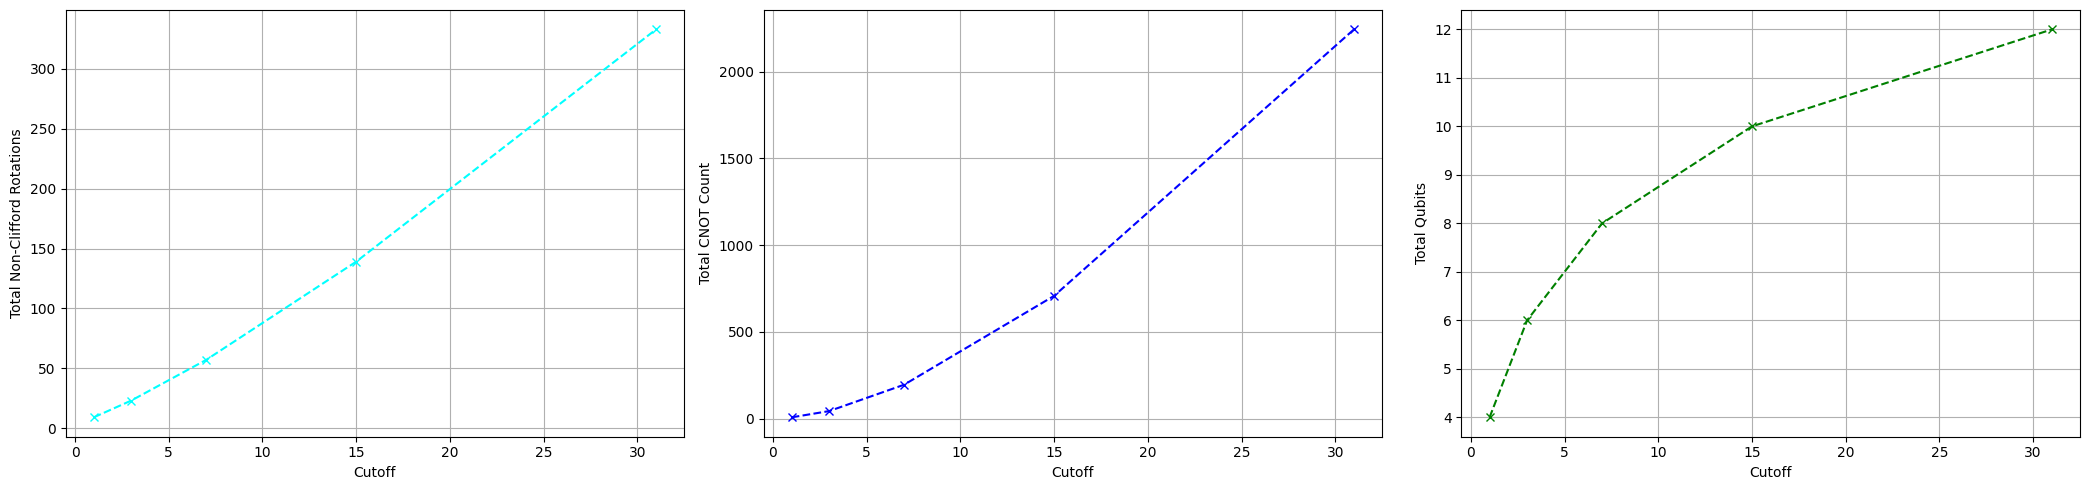

In [5]:
qubit_counts = range(1, 6)  # qubits needed to repressent highest fock state for cutoff K
cutoff_values = [2**q - 1 for q in qubit_counts]  #  cutoffs

cnot_counts = []
nonclifford_counts = []
total_qubit_counts = []


for cutoff in cutoff_values:
    hamiltonian_matrix = holstein_hamiltonian(N_b=cutoff).full()
    H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix)) # convert to sum of pauli strings
    
    terms = H.to_list() # terms as a list of tuples: (pauli_string, coefficient)
    
    total_cnot_count = 0
    for p_str, coeff in terms:
        effective_length = len(p_str.replace('I', '')) # Calculate effective length ignoring 'I'
        total_cnot_count += 2 * max(effective_length - 1, 0) # CNOT count for the current term

    
    cnot_counts.append(total_cnot_count)
    
    # Non-Clifford counts is just no. terms
    nonclifford_count = len(terms)
    nonclifford_counts.append(nonclifford_count)
    
    # total qubits required for this cutoff 
    qubits_per_mode = int(np.ceil(np.log2(cutoff + 1)))
    total_qubits = 2 * qubits_per_mode + 2 #2 sites so 2 modes and 2 qubits
    total_qubit_counts.append(total_qubits)

# plots 
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# Non-Cliffords
axes[0].plot(cutoff_values, nonclifford_counts, marker='x', linestyle='--',  color='cyan')
axes[0].set_xlabel('Cutoff')
axes[0].set_ylabel('Total Non-Clifford Rotations')
axes[0].grid(True)

# CNOTs
axes[1].plot(cutoff_values, cnot_counts, marker='x', linestyle='--',  color='blue')
axes[1].set_xlabel('Cutoff')
axes[1].set_ylabel('Total CNOT Count')
axes[1].grid(True)

# Total qubit
axes[2].plot(cutoff_values, total_qubit_counts, marker='x', linestyle='--', color='green')
axes[2].set_xlabel('Cutoff')
axes[2].set_ylabel('Total Qubits')
axes[2].grid(True)

plt.tight_layout()
plt.show()

For each site you require one qubit for the fermion and $\log_2(n_{\text{max}}+1)$ qubits for the bosonic mode (with cutoff $n_{\text{max}}$). Thus, for $N$ sites the total number of qubits is
$$
N(1+\log_2(n_{max} + 1)).
$$